# Реализация QuartzNet

Для выполнения данного ноутбука нужно иметь распакованный LJSpeech-1.1 на гугл диске<br>
Подтянем все зависимости

In [1]:
!pip install torchaudio

     |████████████████████████████████| 6.7MB 4.8MB/s 


In [2]:
!pip install wandb

     |████████████████████████████████| 1.7MB 7.3MB/s 
     |████████████████████████████████| 102kB 12.3MB/s 
     |████████████████████████████████| 122kB 37.8MB/s 
     |████████████████████████████████| 102kB 12.2MB/s 
     |████████████████████████████████| 163kB 40.2MB/s 
     |████████████████████████████████| 71kB 9.2MB/s 
  Created wheel for watchdog: filename=watchdog-0.10.3-cp36-none-any.whl size=73873 sha256=b4ee43b6136ac6649d738cb95f351ed357804aa055e218c15e4542d162dc3179
  Stored in directory: /root/.cache/pip/wheels/a8/1d/38/2c19bb311f67cc7b4d07a2ec5ea36ab1a0a0ea50db994a5bc7
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp36-none-any.whl size=6489 sha256=be83c14cec84aa9cd8d71e6f14f6668c1bd259b99d11ec9c7bc36b4d0f076cba
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
  Created wheel for pathtools: filename=pathtools-0.1.2-cp36-none-any.whl size=8785 sha256=5165a3e5a88f595f824b9471aaa2ee80d3c59ecbbdfb

In [57]:
import torch
import torchaudio
import pandas as pd
import multiprocessing as mp
from torch import nn
from matplotlib import pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from google.colab import files

# %pylab inline
# from itertools import islice
# from scipy.signal import hann
# from scipy.io import wavfile


подключим логгер

In [58]:
import wandb
!wandb login 32f7df3c332802b239b3a621db53985fe17d319e
wandb.init(project="quartznet-implementation")

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Train loss,0.00148
_step,399
_runtime,10969
_timestamp,1603108890
Test loss,6.56332
Test CER,1.04628
Test WER,1.05166


Train loss,█▇▇▇▇▆▆▇▇▇▆▆▆▆▆▆▆▇▆▅▅▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Test loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Test CER,▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▇▇▆▂▂▂▁▃▆▅▅▆▇▇▇███████
Test WER,▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▇▆▅▂▂▁▁▃▆▅▅▆▇▇▇███████


Подключим диск

In [59]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Будем использовать гпу

In [61]:
use_cuda = torch.cuda.is_available()
torch.manual_seed(7)
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
# mp.set_start_method('fork', True)
# mp.set_start_method('spawn', True)

cuda


Конфиг

In [62]:
# path_to_dataset = "../resources/LJSpeech-1.1/"
path_to_dataset = "drive/My Drive/LJSpeech-1.1/"
path_to_metadata = path_to_dataset + "metadata.csv"
path_to_model = "drive/My Drive/ASR/model.pt"
path_to_weights_dict = "drive/My Drive/ASR/state_dict_model.pt"

batch_size = 32
epochs = 200
n_mels = 64
B = 3
R = 5

freq_mask_param = 15
time_mask_param = 25

column_names = ['wav_filename', 'text_with_numbers', 'text_in_letters'] 
max_str_len = 100

В датасете есть записи с не-ASCII символами (например, французские буквы), уберём их для простоты

In [63]:
def filter_non_ascii(string):
    try:
        str(string).encode('ascii')
    except UnicodeEncodeError:
        return False

    return True

Загружаем метаинформацию о датасете

In [64]:
LJdata = pd.read_csv(path_to_metadata, sep='|', names=column_names, header=None)
LJdata.drop(columns=['text_with_numbers'], inplace=True)
LJdata['text_in_letters'] = LJdata['text_in_letters'].apply(lambda x: str(x))
LJdata = LJdata[LJdata['text_in_letters'].apply(lambda x: len(x) <= max_str_len)]
LJdata = LJdata[LJdata['text_in_letters'].apply(filter_non_ascii)]

In [65]:
LJdata = LJdata[0:32*100]

In [66]:
LJdata

,wav_filename,text_in_letters
1,LJ001-0002,in being comparatively modern.
3,LJ001-0004,"produced the block books, which were the immed..."
5,LJ001-0006,"And it is worth mention in passing that, as an..."
7,LJ001-0008,has never been surpassed.
10,LJ001-0011,it is of the first importance that the letter ...
...,...,...
6526,LJ023-0073,The Court claimed the power to declare it unco...
6527,LJ023-0074,But a little later the Court itself admitted
6530,LJ023-0077,"by which any law is passed,"
6532,LJ023-0079,But since the rise of the modern movement for ...


In [67]:
mel_transform = torchaudio.transforms.MelSpectrogram(
    sample_rate=22050,
    n_fft=1024,
    win_length=1024,
    hop_length=256,
    f_min=0,
    f_max=8000,
    n_mels=n_mels).to(device)

Создадим класс датасет для даталоудера

In [68]:
class MyDataset(Dataset):
    def __init__(self, data):
        super(MyDataset, self).__init__()
        self._data = data

    def __getitem__(self, index: int):
        wav_filename, text_in_letters = self._data.iloc[index]
        path_to_file = path_to_dataset + "wavs/" + wav_filename + ".wav"

        waveform, sample_rate = torchaudio.load(path_to_file)
        waveform = waveform.to(device)
        spectrogram = mel_transform(waveform)
        spectrogram = torch.log(spectrogram + 1e-9)

        return spectrogram, text_in_letters , spectrogram.shape[0] // 2, len(text_in_letters)

    def __len__(self):
        return len(self._data)

In [69]:
my_dataset = MyDataset(LJdata)

код ниже нужно выполнить два раза, на первый раз отваливается из-за диска

3200
in being comparatively modern.
30
0


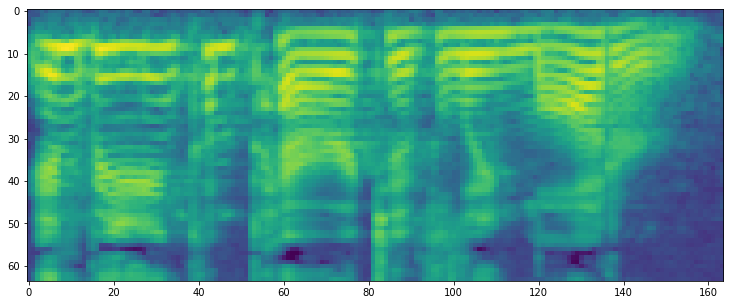

In [70]:
spec, lbl, spec_len, lbl_len = my_dataset.__getitem__(0)
spec = spec.cpu()
print(len(my_dataset))
print(lbl)
print(lbl_len)
print(spec_len)

plt.figure(figsize=(20, 5))
plt.imshow(spec.squeeze())
plt.show()

In [72]:
dataset_length = len(my_dataset)
train_dataset_length = int(dataset_length * 0.95)
test_dataset_length = dataset_length - train_dataset_length

train_dataset, test_dataset = random_split(
    dataset=my_dataset,
    lengths=[train_dataset_length, test_dataset_length],
    generator=torch.Generator().manual_seed(21)
)

print("train set size:", train_dataset_length, "\ntest set size:", test_dataset_length)

train set size: 3040 
test set size: 160


На трейне будем применять аугментации по времени и частоте

In [75]:
def augment(waveform):
    freq_transform = torchaudio.transforms.FrequencyMasking(freq_mask_param=freq_mask_param)
    time_transform = torchaudio.transforms.TimeMasking(time_mask_param=time_mask_param)
    return time_transform(freq_transform(waveform))

In [76]:
char2int = {
        '#': 0,
        ' ': 1,
        'a': 2,
        'b': 3,
        'c': 4,
        'd': 5,
        'e': 6,
        'f': 7,
        'g': 8,
        'h': 9,
        'i': 10,
        'j': 11,
        'k': 12,
        'l': 13,
        'm': 14,
        'n': 15,
        'o': 16,
        'p': 17,
        'q': 18,
        'r': 19,
        's': 20,
        't': 21,
        'u': 22,
        'v': 23,
        'w': 24,
        'x': 25,
        'y': 26,
        'z': 27
    }

int2char = {
        0: '#',
        1: ' ',
        2: 'a',
        3: 'b',
        4: 'c',
        5: 'd',
        6: 'e',
        7: 'f',
        8: 'g',
        9: 'h',
        10: 'i',
        11: 'j',
        12: 'k',
        13: 'l',
        14: 'm',
        15: 'n',
        16: 'o',
        17: 'p',
        18: 'q',
        19: 'r',
        20: 's',
        21: 't',
        22: 'u',
        23: 'v',
        24: 'w',
        25: 'x',
        26: 'y',
        27: 'z'
    }    

In [77]:
def text_transform(text_in_letters):
    int_array = []
    for c in text_in_letters:
        if c in char2int:
            int_array.append(char2int[c])
        
    return int_array

In [78]:
def collate_sequences(batch, is_test = False):
    specs = []
    labels = []
    specs_len = []
    labels_len = []
    for (log_mel_spec, text_in_letters, spec_len, text_len) in batch:
        # if not is_test:
        #     log_mel_spec = augment(log_mel_spec)
        specs.append(log_mel_spec.squeeze(0).transpose(0, 1))
        specs_len.append(log_mel_spec.shape[-1]//2)
        # print(log_mel_spec.shape)
        text_in_ints = torch.Tensor(text_transform(text_in_letters))
        labels.append(text_in_ints)
        labels_len.append(len(text_in_ints))

    specs = nn.utils.rnn.pad_sequence(sequences=specs, batch_first=True).transpose(1, 2)
    labels = nn.utils.rnn.pad_sequence(sequences=labels, batch_first=True)

    return specs, labels, specs_len, labels_len

In [79]:
train_dataloader = DataLoader(
            train_dataset,
            batch_size=batch_size,
            collate_fn=collate_sequences,
            num_workers=0
            # pin_memory=True
        )

test_dataloader = DataLoader(
            test_dataset,
            batch_size=batch_size,
            collate_fn=lambda x: collate_sequences(x, True),
            num_workers=0
            # pin_memory=True
        )

Определим модель сети

In [80]:
class Conv_BN_ReLU(nn.Module):
    def __init__(self, in_channels, out_channels, kernel, stride = 1):
        super(Conv_BN_ReLU, self).__init__()
        
        self.cnn = nn.Conv1d(
            in_channels, out_channels, kernel, stride=stride, padding=kernel//2
        )
        self.batch_norm = nn.modules.batchnorm.BatchNorm1d(
            num_features=out_channels
        )
        self.relu = nn.ReLU(inplace = False)

    def forward(self, x):
        x = self.cnn(x)
        x = self.batch_norm(x)
        x = self.relu(x)
        return x  # (batch, channel, feature, time)

In [81]:
class TCSConv_BN_ReLU(nn.Module):
    def __init__(self, in_channels, out_channels, kernel):
        super(TCSConv_BN_ReLU, self).__init__()

        self.depthwise_conv = nn.Conv1d(
            in_channels, in_channels, kernel_size=kernel, padding=kernel//2,
            groups=4, bias=False
        )
        self.pointwise_conv = nn.Conv1d(
            in_channels, out_channels, kernel_size=1, padding=0, bias=False
        )
        self.batch_norm = nn.modules.batchnorm.BatchNorm1d(
            num_features=out_channels
        )
        self.relu = nn.ReLU(inplace = False)

    def forward(self, x):
        x = self.depthwise_conv(x)
        x = self.pointwise_conv(x)
        x = self.batch_norm(x)
        x = self.relu(x)
        return x  # (batch, channel, feature, time)

In [82]:
print("R =", R)
print("B =", B)

R = 5
B = 3


In [83]:
class TCSBlock(nn.Module):
    """Layer normalization built for cnns input"""
    def __init__(self, in_channels, out_channels, kernel):
        super(TCSBlock, self).__init__()
        
        self.TCS_layers = nn.Sequential(*[
            TCSConv_BN_ReLU(in_channels, out_channels, kernel)
            for i in range(R)
        ])
        
    def forward(self, x):
        x_copy = x
        x = self.TCS_layers(x)
        x += x_copy
        return x  # (batch, channel, feature, time)

In [84]:
class MainBlock(nn.Module):
    def __init__(self):
        super(MainBlock, self).__init__()
        
        self.TCSBlock_1 = TCSBlock(in_channels=256, out_channels=256, kernel=33)
        self.TCSBlock_2 = TCSBlock(in_channels=256, out_channels=256, kernel=39)
        self.helper_2_3 = Conv_BN_ReLU(in_channels=256, out_channels=512, kernel=51)
        self.TCSBlock_3 = TCSBlock(in_channels=512, out_channels=512, kernel=51)
        self.TCSBlock_4 = TCSBlock(in_channels=512, out_channels=512, kernel=63)
        self.TCSBlock_5 = TCSBlock(in_channels=512, out_channels=512, kernel=75)

    def forward(self, x):
        # x (batch, channel, feature, time)
        x = self.TCSBlock_1(x)
        x = self.TCSBlock_2(x)
        x = self.helper_2_3(x)
        x = self.TCSBlock_3(x)
        x = self.TCSBlock_4(x)
        x = self.TCSBlock_5(x)
        return x  # (batch, channel, feature, time)

In [85]:
class ASR(nn.Module):
    def __init__(self):
        super(ASR, self).__init__()
        
        self.conv_bn_relu_1 = Conv_BN_ReLU(
            in_channels=64, out_channels=256, kernel=33, stride=2
        )
        self.main_block = MainBlock()
        self.conv_bn_relu_2 = Conv_BN_ReLU(in_channels=512, out_channels=512, kernel=87)
        self.conv_bn_relu_3 = Conv_BN_ReLU(in_channels=512, out_channels=1024, kernel=1)
        self.conv_bn_relu_4 = nn.Conv1d(in_channels=1024, out_channels=len(char2int), kernel_size=1, padding=0, dilation=2, bias=False)
    
    def forward(self, x):
        # x (batch, channel, feature, time)
        x = self.conv_bn_relu_1(x)
        x = self.main_block(x)
        x = self.conv_bn_relu_2(x)
        x = self.conv_bn_relu_3(x)
        x = self.conv_bn_relu_4(x)
        x = x.transpose(1, 2)
        return x  # (batch, channel, feature, time)

In [86]:
model=ASR().to(device)
wandb.watch(model)

In [87]:
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4)

In [88]:
criterion = nn.CTCLoss(blank=0).to(device)

In [89]:
log_softmax = nn.LogSoftmax(dim=2)

In [90]:
print(len(train_dataloader.dataset))
print(len(test_dataloader.dataset))

3040
160


In [92]:
def int_to_letters(text_in_ints):
    string = []
    for i in text_in_ints:
        string.append(int2char[i])
    return ''.join(string)


In [93]:
def Decoder(output, labels, label_lengths, blank_label=0, collapse_repeated=True):
    arg_maxes = torch.argmax(output, dim=2)
    decodes = []
    targets = []
    for i, args in enumerate(arg_maxes):
        decode = []
        targets.append(int_to_letters(labels[i][:label_lengths[i]].tolist()))
        for j, index in enumerate(args):
            if index != blank_label:
                if collapse_repeated and j != 0 and index == args[j -1]:
                    continue
                decode.append(index.item())
        decodes.append(int_to_letters(decode))
    return decodes, targets

In [36]:
!pip install python-Levenshtein

     |████████████████████████████████| 51kB 3.1MB/s 
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.0-cp36-cp36m-linux_x86_64.whl size=144790 sha256=5e7d52a5799ae62d7f0ba69ec11ac2eb8832887996136cd28887af080e7ff8d6
  Stored in directory: /root/.cache/pip/wheels/de/c2/93/660fd5f7559049268ad2dc6d81c4e39e9e36518766eaf7e342
Successfully built python-Levenshtein


In [94]:
import Levenshtein

Определим WER и CER

In [95]:
def wer(reference, hypothesis, delimiter=' '):

    reference = reference.lower()
    hypothesis = hypothesis.lower()

    # ref_words = reference.split(delimiter)
    # hyp_words = hypothesis.split(delimiter)

    # print("ref:\n", reference, "\nhyp:\n", hypothesis)
    edit_distance = Levenshtein.distance(reference, hypothesis)

    wer = float(edit_distance) / len(reference)
    return wer

In [96]:
def cer(reference, hypothesis, remove_space=False):

    reference = reference.lower()
    hypothesis = hypothesis.lower()
    join_char = ' '
    if remove_space == True:
        join_char = ''

    reference = join_char.join(filter(None, reference.split(' ')))
    hypothesis = join_char.join(filter(None, hypothesis.split(' ')))

    edit_distance = Levenshtein.distance(reference, hypothesis)

    cer = float(edit_distance) / len(reference)
    return cer

In [97]:
def train(model, train_dataloader, criterion, optimizer, epoch):
    model.train()
    data_len = len(train_dataloader.dataset)
    #print(data_len)
    losses = []
    for batch_idx, (log_mel_specs, texts_in_ints, spec_lengths, lbl_lengths) in enumerate(train_dataloader):
        log_mel_specs = log_mel_specs.to(device)
        texts_in_ints = texts_in_ints.to(device)

        optimizer.zero_grad()

        output = model(log_mel_specs)  # (batch, time, n_class)
        #print(output.shape)
        #print(output)
        output = log_softmax(output)
        #print(output.shape)
        #print(output)
        output = output.transpose(0, 1) # (time, batch, n_class)

        loss = criterion(output, texts_in_ints, spec_lengths, lbl_lengths)
        loss.backward()
        losses.append(loss)

        optimizer.step()
        if batch_idx == 1 and (epoch == 0 or epoch % 10 == 1):
            decodes, targets = Decoder(
                output.transpose(0, 1), texts_in_ints, lbl_lengths, blank_label=0, collapse_repeated=True
            )
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(log_mel_specs), data_len,
                100. * batch_idx / len(train_dataloader), loss.item()))
            print("Decodes:\n", decodes)
            print("Targets:\n", targets)
    wandb.log({"Train loss": sum(losses) / len(losses)})
    return sum(losses) / len(losses)

In [98]:
def test(model, test_dataloader, criterion, epoch):
    model.eval()
    test_loss = 0
    test_cer, test_wer = [], []
    with torch.no_grad():
        for batch_idx, (log_mel_specs, texts_in_ints, spec_lengths, lbl_lengths) in enumerate(test_dataloader):
            log_mel_specs = log_mel_specs.to(device)
            texts_in_ints = texts_in_ints.to(device)

            output = model(log_mel_specs)  # (batch, time, n_class)
            output = log_softmax(output)
            output = output.transpose(0, 1) # (time, batch, n_class)

            loss = criterion(output, texts_in_ints, spec_lengths, lbl_lengths)
            # print("loss =", loss.item(), "dataloader len =", len(test_dataloader))
            test_loss += loss.item() / len(test_dataloader)

            decoded_preds, decoded_targets = Decoder(
                output.transpose(0, 1), texts_in_ints, lbl_lengths, blank_label=0, collapse_repeated=True
            )
            if (epoch % 10 == 1):
                print("Decoded predictions:\n", decoded_preds)
                print("Decoded rargets:\n", decoded_targets)
            for j in range(len(decoded_preds)):
                test_cer.append(cer(decoded_targets[j], decoded_preds[j]))
                test_wer.append(wer(decoded_targets[j], decoded_preds[j]))


    avg_cer = sum(test_cer)/len(test_cer)
    avg_wer = sum(test_wer)/len(test_wer)
    
    if (epoch % 10 == 1):
        print('Test set: Average loss: {:.4f}, Average CER: {:4f} Average WER: {:.4f}\n'.format(test_loss, avg_cer, avg_wer))
    wandb.log({"Test loss": test_loss, "Test CER": avg_cer, "Test WER": avg_wer})
    return test_loss, avg_cer, avg_wer


Наконец, будем учить нашу модель и смотреть на результаты


In [ ]:
# train_losses = []
# test_losses = []
# test_avg_cers = []
# test_avg_wers = []

for epoch in range(epochs):
  train_avg_loss = train(model, train_dataloader, criterion, optimizer, epoch)
  # train_losses.append(train_avg_loss)
  test_avg_loss, test_avg_cer, test_avg_wer = test(model, test_dataloader, criterion, epoch)
  # test_losses.append(test_avg_loss)
  # test_avg_cers.append(test_avg_cer)
  # test_avg_wers.append(test_avg_wer)

model = model.to("cpu")
torch.save(model.state_dict(), 'model_state_dict.pt')
files.download('model_state_dict.pt')
model = model.to(device)

Train Epoch: 0 [32/3040 (1%)]	Loss: 6.524331
Decodes:
 ['h pcpbpuhwpuphum', 'huhuhuhum', 'hrhpwpwupuhuhuhuhum', 'hprwmhum', 'hrhphpwpwpuhuhuhuhuhuhuhuhum', 'huhuhum', 'hrphuhuhuhuhuhuhuhum', 'hotptprprtrptprpupuhuhum', 'hrhum', 'h  puphuhum', 'hcocbwbpbpbupupuhum', 'hwhwpwpwpuhum', 'hprhwhuhuhuhuhuhum', 'hum', 'h rprphuhumpm', 'huhuhuhuhuhuhuhuhum', 'hprphrhpwpuruhuhuhuhuhum', 'hococbqpqm', 'hocbmpm', 'hr t tp puhum', 'hprhuhuhum', 'hwpwpuwpuhuhuhuhuhuhum', 'hcpcpbcbpumuhuhuhum', 'huhuhuhuhwuhuhuhuhuhuhum', 'hwrwpuhmhjuhuhum', 'hocobcqpqbpupupuhuhum', 'hprprumh r rpruhum', 'hoowcpm', 'hpwpwuhuhuhum', 'h puhum', 'hphrhuhuhum', 'hocm']
Targets:
 ['till no sentence of death was carried out for the offense and in eighteen thirtytwo', 'was the state of her fathers affairs', 'aynard was the only one who suffered death', 'auntleroy was not entirely dependent upon the ordinary for ghostly counsel in his extremity', 'unless they could afford to pay for a vehicle out of their own funds', 'e trav

In [ ]:
files.upload()
# import model_state_dict.pt

In [ ]:
model = ASR()
state_dict = torch.load('model_state_dict.pt')
model.load_state_dict(state_dict)
model = model.to(device)

In [ ]:
plt.figure(figsize=(20, 5))
plt.plot(range(epochs), train_losses)
plt.show()

NameError: ignored

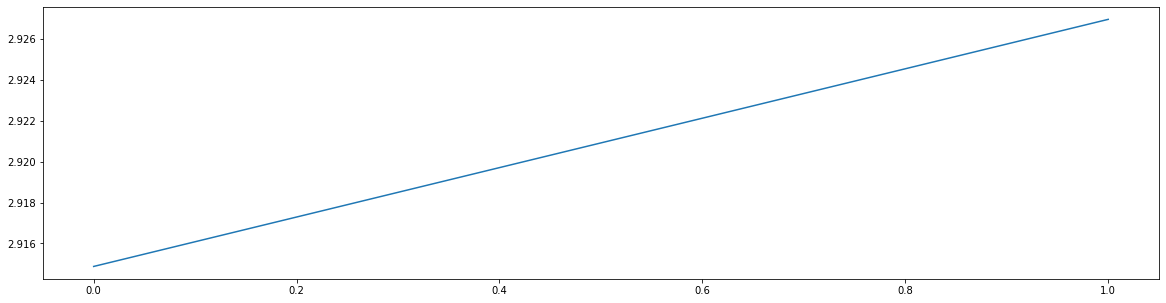

In [ ]:
plt.figure(figsize=(20, 5))
plt.plot(range(epochs), test_losses)
plt.show()

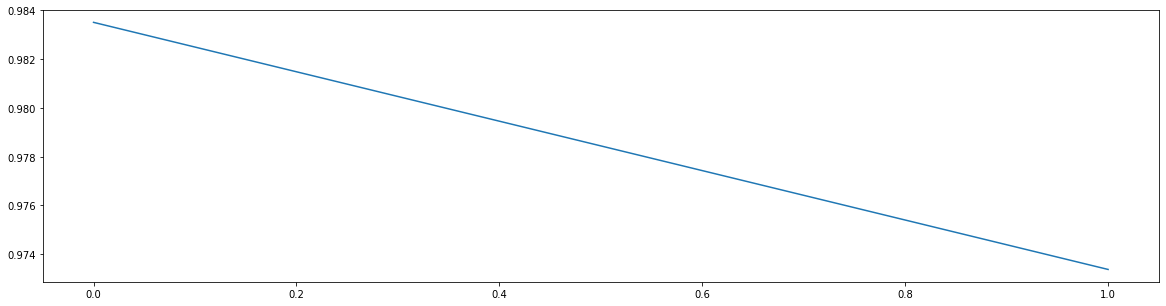

In [ ]:
plt.figure(figsize=(20, 5))
plt.plot(range(epochs), test_avg_cers)
plt.show()

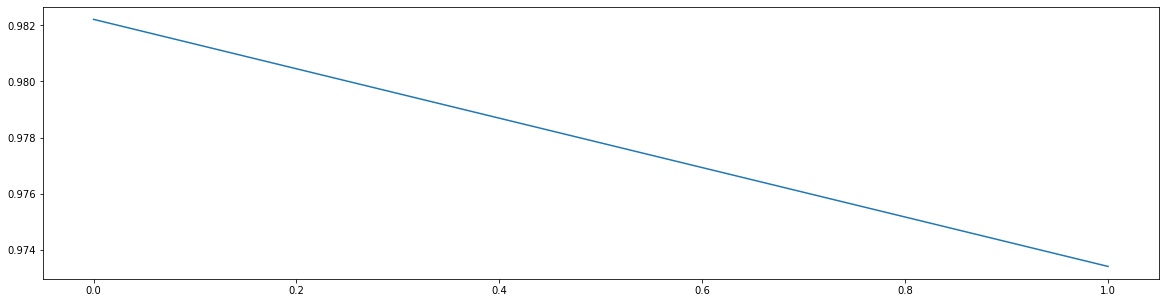

In [ ]:
plt.figure(figsize=(20, 5))
plt.plot(range(epochs), test_avg_wers)
plt.show()